In [122]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

device = 'cuda'

In [123]:
class LSTMModel(nn.Module):

  def __init__(self, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(1, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
        output_lstm, (hidden_lstm, cell_lstm) = self.lstm(x)
        last_hidden = hidden_lstm[-1,:,:]
        output = self.fc(last_hidden)
        return output

In [124]:
df = pd.read_csv('FPT.csv')
df.drop(columns=['Ticker','Open Interest'],inplace=True)
df.head()

,Date/Time,Open,High,Low,Close,Volume
0,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410
1,12/25/2018 9:16,30.81,30.81,30.81,30.81,190
2,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120
3,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120
4,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500


In [125]:
df.set_index('Date/Time',inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date/Time,,,,,
12/25/2018 9:15,30.89,30.89,30.89,30.89,35410
12/25/2018 9:16,30.81,30.81,30.81,30.81,190
12/25/2018 9:17,30.74,30.81,30.74,30.74,1120
12/25/2018 9:18,30.74,30.74,30.74,30.74,2120
12/25/2018 9:19,30.74,30.74,30.74,30.74,22500


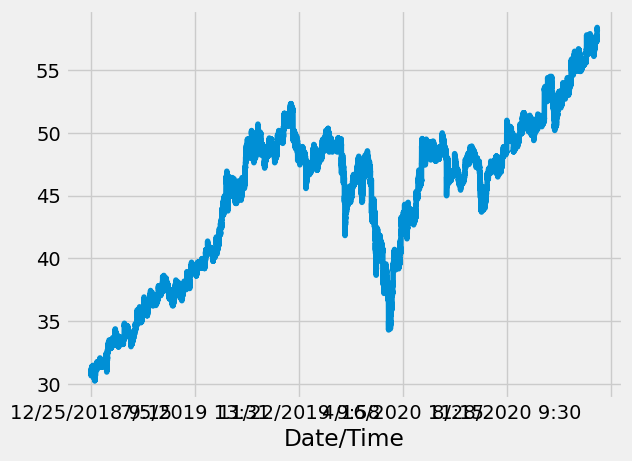

In [126]:
plt.style.use('fivethirtyeight')

df['Open'].plot()
plt.show()

In [127]:
df.index = pd.to_datetime(df.index)

In [128]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour
df['Minute'] = df.index.minute
df.head()

,Open,High,Low,Close,Volume,Year,Month,Day,Hour,Minute
Date/Time,,,,,,,,,,
2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,2018,12,25,9,15
2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,2018,12,25,9,16
2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,2018,12,25,9,17
2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,2018,12,25,9,18
2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,2018,12,25,9,19


In [129]:
def create_sequences(data, lag, ahead, feature_cols, target_col):
    """
    Create sequences from time series data for use in time series forecasting.

    Parameters:
    - data (pd.DataFrame): The time series data as a pandas DataFrame.
    - lag (int): The number of data points in each input sequence.
    - ahead (int): The number of data points to predict in the future.
    - feature_cols (list): List of column names to include in the input sequences.
    - target_col (str): The column name of the target variable.

    Returns:
    - X (numpy.ndarray): A 3D array of shape (num_sequences, lag, num_features) containing the input sequences.
    - y (numpy.ndarray): A 2D array of shape (num_sequences, ahead) containing the corresponding labels.
    """
    X, y = [], []
    for i in range(len(data) - lag - ahead + 1):
        # Select lag data points for the features
        X_seq = data.iloc[i:(i + lag)][feature_cols].values
        # Select ahead data points for the target variable
        y_seq = data.iloc[(i + lag):(i + lag + ahead)][target_col].values
        X.append(X_seq)
        y.append(y_seq)

    return np.array(X), np.array(y)

# Example usage
# Assuming `df` is your DataFrame with the given structure
# Columns to use as features
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Day', 'Hour', 'Minute']
# Column to predict (e.g., 'Close')
target_col = 'Close'

# Set lag and ahead values
lag = 3  # Number of past observations
ahead = 1  # Number of steps to forecast

# Create sequences
X, y = create_sequences(df, lag, ahead, feature_cols, target_col)

In [130]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_data(data, lag, ahead, train_ratio, batch_size, feature_cols, target_col):
    """
    Prepare the data for the Conv1D model training.

    Parameters:
    - data (pd.DataFrame): The raw time series data as a DataFrame.
    - lag (int): The number of time steps to use for predictions.
    - ahead (int): The number of time steps ahead to predict.
    - train_ratio (float): The ratio of the dataset to include in the train split.
    - batch_size (int): The size of the batch for the DataLoader.
    - feature_cols (list): List of column names to use as input features.
    - target_col (str): The column name of the target variable.

    Returns:
    - train_loader: DataLoader for the training set.
    - X_test_tensor: PyTorch tensor for the test features.
    - y_test_tensor: PyTorch tensor for the test labels.
    """
    # Create sequences using the modified create_sequences function
    X, y = create_sequences(data, lag, ahead, feature_cols, target_col)

    # Flatten the feature dimensions for LSTM input
    X = X.reshape(X.shape[0], -1, 1)

    # Split into train and test sets
    train_size = int(len(X) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training data
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    return train_loader, X_test_tensor, y_test_tensor

def train_model(model, criterion, optimizer, train_loader, num_epochs):
    """
    Train the model and return the best model based on training loss.

    Parameters:
    - model: The PyTorch model to train.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - train_loader: DataLoader for the training set.
    - num_epochs: The number of epochs to train for.

    Returns:
    - best_model: The model with the lowest training loss.
    - losses: A list of loss values per epoch.
    """
    best_loss = float('inf')
    best_model = None
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for this epoch
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Save the model if it has the lowest loss so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = model.state_dict()  # Save the state_dict of the best model

    print(f"Training complete. Best loss achieved: {best_loss:.4f}")
    model.load_state_dict(best_model)  # Load the best model weights
    return model, losses

def plot_losses(losses):
    """
    Plot the training losses.

    Parameters:
    - losses: A list of loss values per epoch.
    """
    plt.plot(losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [131]:
num_epochs = 200
train_ratio = 0.8
batch_size = 64
lr = 0.001

In [132]:
lag = 64
ahead = 1
hidden_dim = 32

In [133]:
train_loader, X_test_tensor, y_test_tensor = prepare_data(df, lag, ahead, train_ratio, batch_size,feature_cols,target_col)
model = LSTMModel(hidden_dim=hidden_dim, output_dim=ahead)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model, losses = train_model(model, criterion, optimizer, train_loader, num_epochs)

Epoch [1/200], Loss: 766.8087
Epoch [2/200], Loss: 50.7860
Epoch [3/200], Loss: 2.7330
Epoch [4/200], Loss: 0.4527
Epoch [5/200], Loss: 0.2580
Epoch [6/200], Loss: 0.3312
Epoch [7/200], Loss: 0.1705
Epoch [8/200], Loss: 0.1388
Epoch [9/200], Loss: 0.1272
Epoch [10/200], Loss: 0.1147
Epoch [11/200], Loss: 0.1002
Epoch [12/200], Loss: 0.0864
Epoch [13/200], Loss: 0.0721
Epoch [14/200], Loss: 0.0642
Epoch [15/200], Loss: 0.0622
Epoch [16/200], Loss: 0.0531
Epoch [17/200], Loss: 0.0479
Epoch [18/200], Loss: 0.0434
Epoch [19/200], Loss: 0.0403
Epoch [20/200], Loss: 0.0376
Epoch [21/200], Loss: 0.0318
Epoch [22/200], Loss: 0.0297
Epoch [23/200], Loss: 0.0282
Epoch [24/200], Loss: 0.0274
Epoch [25/200], Loss: 0.0240
Epoch [26/200], Loss: 0.0229
Epoch [27/200], Loss: 0.0222
Epoch [28/200], Loss: 0.0205
Epoch [29/200], Loss: 0.0199
Epoch [30/200], Loss: 0.0195
Epoch [31/200], Loss: 0.0179
Epoch [32/200], Loss: 0.0181
Epoch [33/200], Loss: 0.0178
Epoch [34/200], Loss: 0.0169
Epoch [35/200], Loss

In [134]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model_in_batches(model, X_test_tensor, y_test_tensor, ahead, batch_size=64, use_gpu=True):
    """
    Evaluate the model in batches to avoid out-of-memory issues.

    Parameters:
    - model: The PyTorch model to evaluate.
    - X_test_tensor: PyTorch tensor for the test features.
    - y_test_tensor: PyTorch tensor for the test labels.
    - ahead: The number of time steps ahead that the model predicts.
    - batch_size: The batch size to use for evaluation.
    - use_gpu: Whether to use GPU for evaluation (set False to use CPU).

    Returns:
    - r2: R-squared score.
    - mae: Mean Absolute Error.
    - mse: Mean Squared Error.
    - predictions: The model predictions.
    - y_test: The true test labels.
    """
    # Chuyển mô hình sang CPU nếu bộ nhớ GPU bị hạn chế
    if not use_gpu:
        model = model.to("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")

    model.eval()
    predictions, y_test = [], []

    # Load dữ liệu test theo batch
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences = sequences.to(device)
            batch_predictions = model(sequences).cpu().numpy()  # Dự đoán và chuyển về CPU
            predictions.append(batch_predictions)
            y_test.append(labels.numpy())

    # Ghép và reshape dự đoán để phù hợp với định dạng y_test
    predictions = np.vstack(predictions).reshape(-1, ahead)
    y_test = np.vstack(y_test)

    # Tính toán các chỉ số
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)

    print(f'R2 Score: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')

    return r2, mae, mse, predictions, y_test

# Giải phóng bộ nhớ GPU trước khi chạy đánh giá
torch.cuda.empty_cache()

# Đánh giá mô hình với batch nhỏ hơn hoặc trên CPU
r2, mae, mse, predictions, y_test = evaluate_model_in_batches(model, X_test_tensor, y_test_tensor, ahead, batch_size=64, use_gpu=False)

# Hiển thị predictions và y_test nếu cần thiết
print(f'Predictions: {predictions[:5]}')  # Hiển thị 5 dự đoán đầu tiên
print(f'Ground Truth: {y_test[:5]}')  # Hiển thị 5 giá trị thực tế đầu tiên

R2 Score: 0.750407338142395
MAE: 0.9302988648414612
MSE: 2.099428176879883
Predictions: [[48.171818]
 [48.161247]
 [48.150066]
 [48.123405]
 [48.171722]]
Ground Truth: [[48.15]
 [48.15]
 [48.15]
 [48.1 ]
 [48.15]]


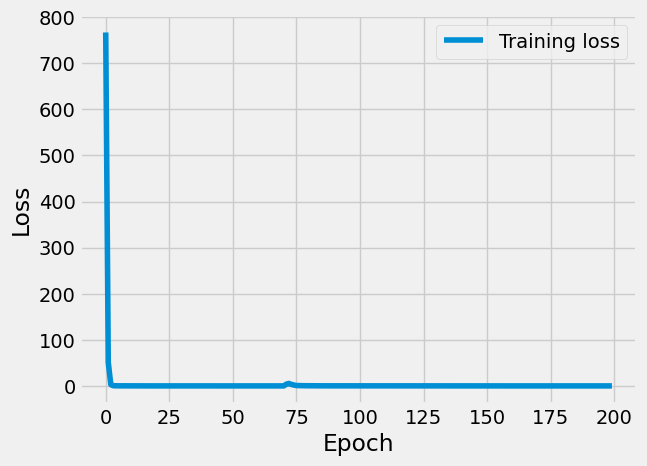

In [135]:
plot_losses(losses)

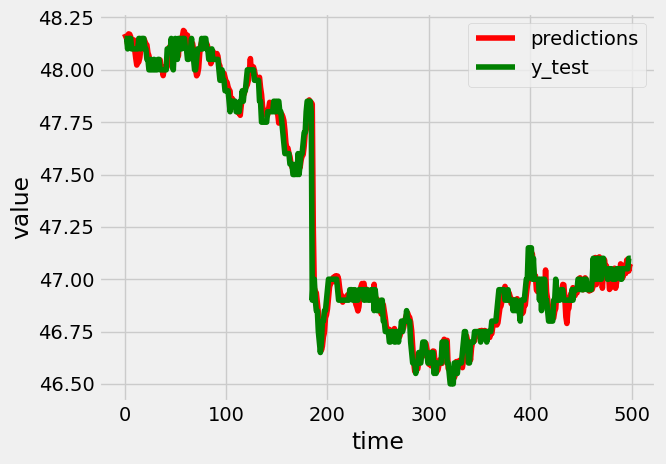

In [136]:
plt.plot(predictions[:500,0], 'r', label='predictions')
plt.plot(y_test[:500,0], 'g', label='y_test')

plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()